In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Capstone_Project/dataset_202403070445.csv')
dataset.shape

(956, 26)

# Data Cleansing

In [ ]:
dataset['price'] = (dataset['price'] * 1000000).astype('int') #Menyesuaikan nominal pada kolom price
dataset.head(2)

,id,city,city_min_wage,building_area,land_area,bedroom,bathroom,kitchen,dining_room,living_room,...,electricity,water_source,cctv,ac,location,cond,legality,negotiable,est_installment,price
0,16485968,tangerang,4681138,150.0,112,4.0,3.0,0,0,0,...,2200.0,PDAM,0,1,Kompleks/Perumahan/Cluster,Bagus,SHM,0,7089220,1100000000
1,16441561,jakarta selatan,5067381,200.0,452,5.0,3.0,0,0,0,...,NaN,NaN,0,0,Kompleks/Perumahan/Cluster,Perlu renovasi,SHM,0,54780337,8500000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               956 non-null    int64  
 1   city             956 non-null    object 
 2   city_min_wage    956 non-null    int64  
 3   building_area    955 non-null    float64
 4   land_area        956 non-null    int64  
 5   bedroom          937 non-null    float64
 6   bathroom         933 non-null    float64
 7   kitchen          956 non-null    int64  
 8   dining_room      956 non-null    int64  
 9   living_room      956 non-null    int64  
 10  furnishing       778 non-null    object 
 11  storeroom        956 non-null    int64  
 12  laundry          956 non-null    int64  
 13  garage           956 non-null    int64  
 14  carport          956 non-null    int64  
 15  floor_count      955 non-null    float64
 16  electricity      776 non-null    float64
 17  water_source    

In [ ]:
dataset.isnull().sum()

id                   0
city                 0
city_min_wage        0
building_area        1
land_area            0
bedroom             19
bathroom            23
kitchen              0
dining_room          0
living_room          0
furnishing         178
storeroom            0
laundry              0
garage               0
carport              0
floor_count          1
electricity        180
water_source       255
cctv                 0
ac                   0
location           351
cond               158
legality            11
negotiable           0
est_installment      0
price                0
dtype: int64

In [ ]:
#Menghapus kolom dengan nilai null lebih dari 96 (10% data tiap kolom)
to_drop = ['location', 'water_source', 'furnishing', 'electricity', 'cond']
df = dataset.drop(to_drop, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               956 non-null    int64  
 1   city             956 non-null    object 
 2   city_min_wage    956 non-null    int64  
 3   building_area    955 non-null    float64
 4   land_area        956 non-null    int64  
 5   bedroom          937 non-null    float64
 6   bathroom         933 non-null    float64
 7   kitchen          956 non-null    int64  
 8   dining_room      956 non-null    int64  
 9   living_room      956 non-null    int64  
 10  storeroom        956 non-null    int64  
 11  laundry          956 non-null    int64  
 12  garage           956 non-null    int64  
 13  carport          956 non-null    int64  
 14  floor_count      955 non-null    float64
 15  cctv             956 non-null    int64  
 16  ac               956 non-null    int64  
 17  legality        

In [ ]:
df_num = df[['city_min_wage', 'building_area', 'land_area', 'bedroom', 'bathroom', 'kitchen', 'garage', 'carport', 'floor_count']]
df_ctg = df[['dining_room', 'living_room','storeroom', 'laundry', 'cctv', 'ac', 'legality']]
info = {'var_numerik': [df_num.shape[1]],
        'var_kategorial': [df_ctg.shape[1]]}
var_count = pd.DataFrame(data=info)
var_count

,var_numerik,var_kategorial
0,9,7


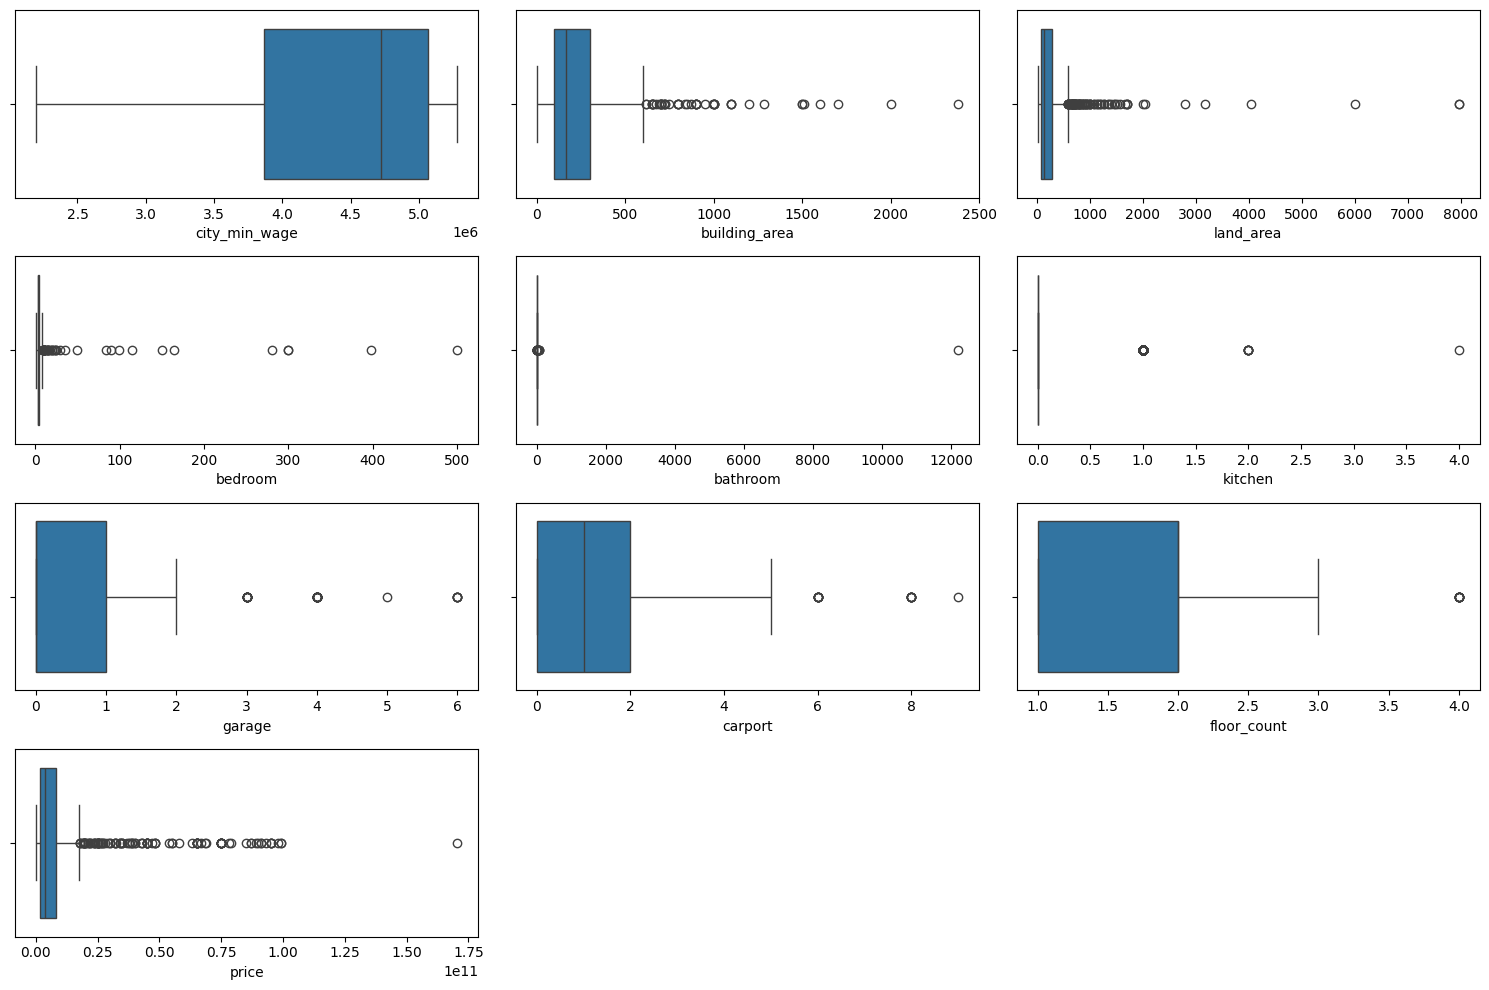

In [ ]:
cols = df_num.columns.to_list() + ['price']

fig = plt.figure(facecolor='w', figsize=(15, 10))

for i, col in list(enumerate(cols)):
  ax = fig.add_subplot(4,3,i+1)
  sns.boxplot(x=df[col])
  fig.tight_layout()

plt.show()

In [ ]:
#Menghapus outlier untuk building_area, land_area, bedroom, bathroom, dan electricity
def outlier(df, col):
  iqr = (np.nanquantile(df[col], 0.75) - np.nanquantile(df[col], 0.25))*1.5
  ol_lower = df[df[col] < (np.nanquantile(df[col], 0.25) - iqr)].index.to_list()
  ol_upper = df[df[col] > (np.nanquantile(df[col], 0.75) + iqr)].index.to_list()
  return ol_lower + ol_upper  #return index outlier

to_clean = ['building_area', 'land_area', 'bedroom', 'bathroom', 'price']
idx = []

for col in to_clean:
  idx = idx + outlier(df, col)

df_no_outlier = df.drop(idx, axis=0)
df_no_outlier.reset_index(drop=True, inplace=True)
df_no_outlier.shape

(741, 21)

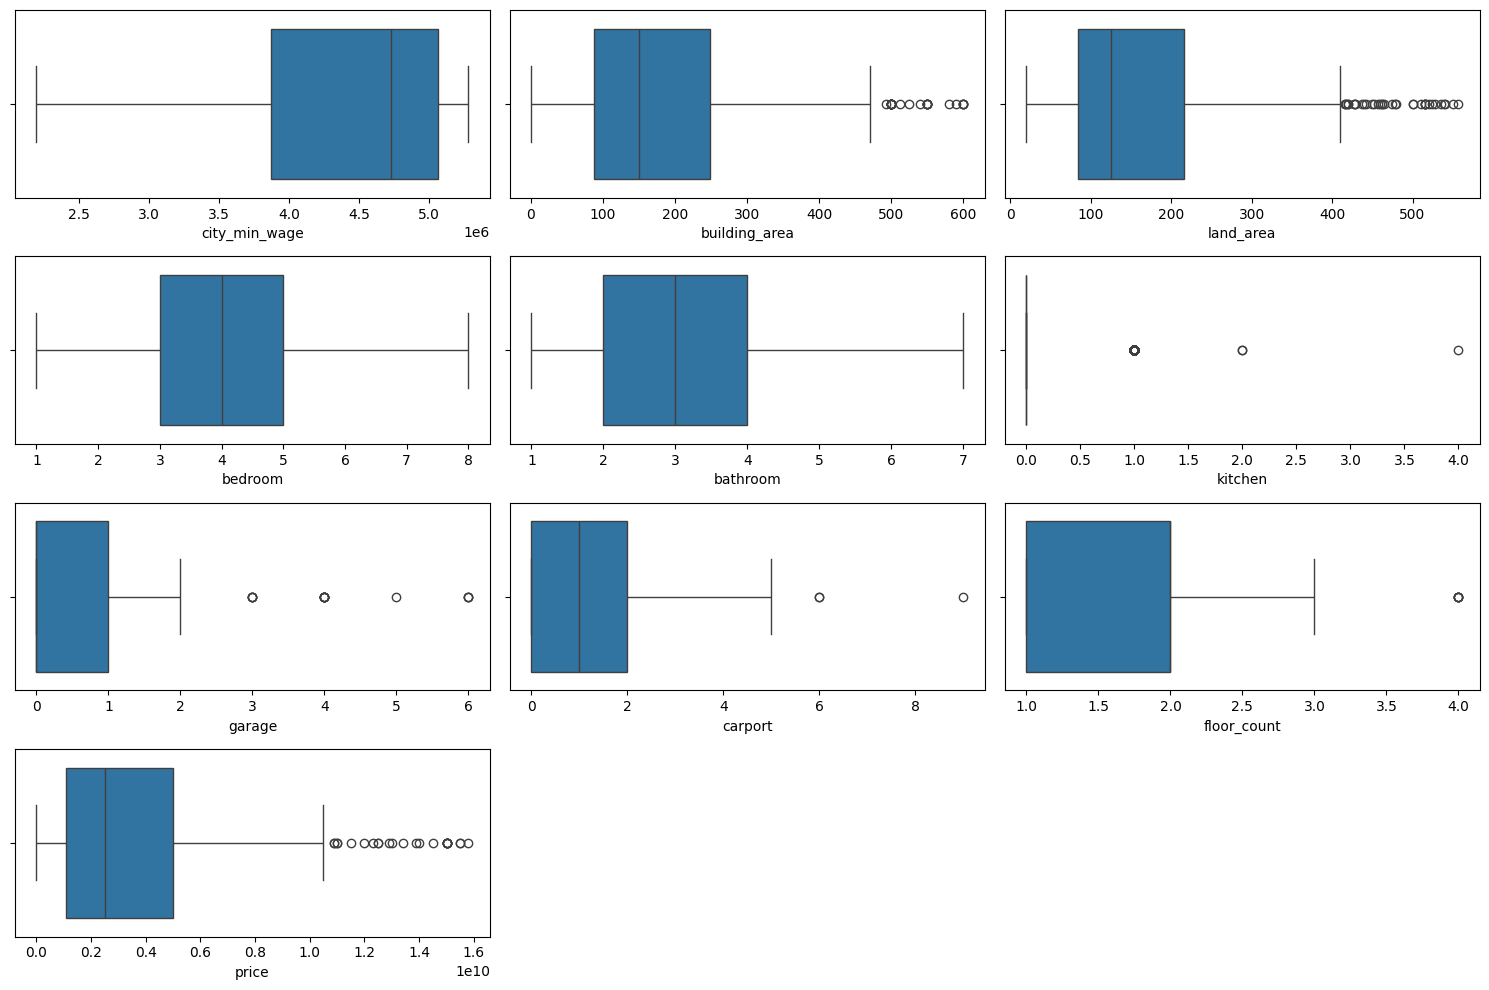

In [ ]:
cols = df_num.columns.to_list() + ['price']

fig = plt.figure(facecolor='w', figsize=(15, 10))

for i, col in list(enumerate(cols)):
  ax = fig.add_subplot(4,3,i+1)
  sns.boxplot(x=df_no_outlier[col])
  fig.tight_layout()

plt.show()

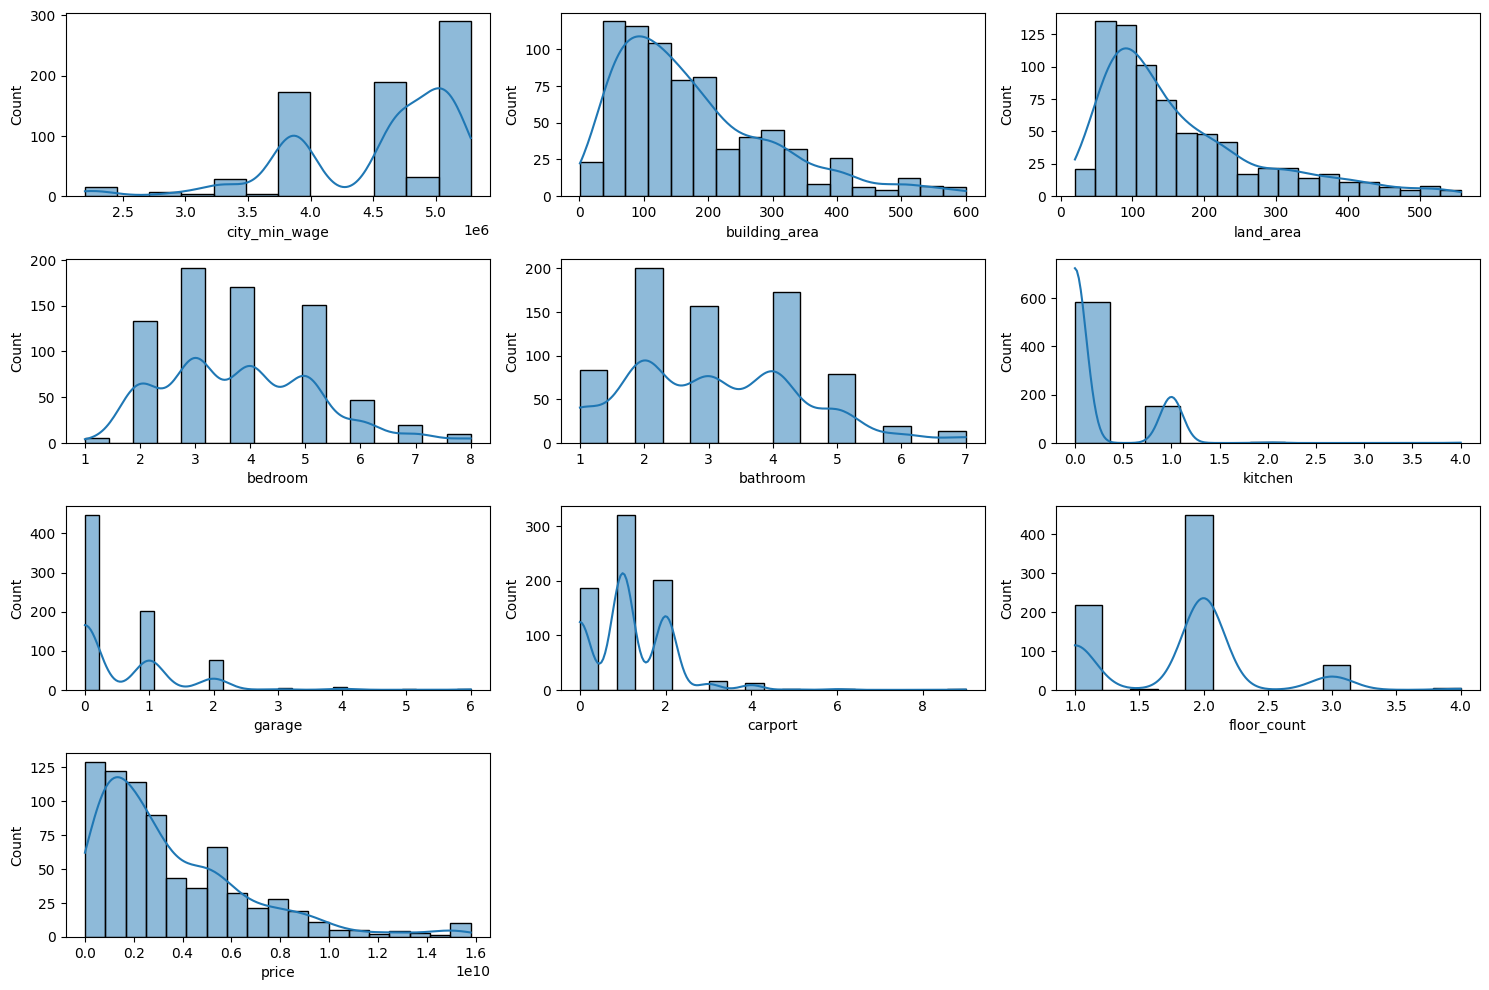

In [ ]:
cols = df_num.columns.to_list() + ['price']

fig = plt.figure(facecolor='w', figsize=(15, 10))

for i, col in list(enumerate(cols)):
  ax = fig.add_subplot(4,3,i+1)
  sns.histplot(x=df_no_outlier[col], kde=True)
  fig.tight_layout()

plt.show()

In [ ]:
df_no_outlier.isnull().sum()[df_no_outlier.isnull().sum() != 0].index #variabel dengan missing value

Index(['building_area', 'bedroom', 'bathroom', 'floor_count', 'legality'], dtype='object')

In [ ]:
#Cek keselarasan value variabel kategori sebelum menggunakan imputer
ctg = [ 'dining_room', 'living_room','storeroom', 'laundry', 'cctv', 'ac', 'legality']

for col in ctg:
  print(col, ':', df_no_outlier[col].unique())

dining_room : [0 1]
living_room : [0 1]
storeroom : [0 1]
laundry : [1 0]
cctv : [0 1]
ac : [1 0]
legality : ['SHM' 'HGB' 'Lainnya' nan]


In [ ]:
#Set imputer untuk mengisi missing value
num_imputer = SimpleImputer(missing_values=np.NaN, strategy='median') #Karena semua kolom numerik tidak berdistribusi normal, maka digunakan
const_imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='Lainnya')

In [ ]:
num = ['building_area', 'bedroom', 'bathroom', 'kitchen', 'floor_count']
const = ['legality']

In [ ]:
df_clean = df_no_outlier
df_clean[num] = num_imputer.fit_transform(df_clean[num])
df_clean[const] = const_imputer.fit_transform(df_clean[const])

In [ ]:
df_clean[['building_area', 'bedroom', 'bathroom', 'kitchen']] = df_clean[['building_area', 'bedroom', 'bathroom', 'kitchen']].astype('int')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               741 non-null    int64  
 1   city             741 non-null    object 
 2   city_min_wage    741 non-null    int64  
 3   building_area    741 non-null    int64  
 4   land_area        741 non-null    int64  
 5   bedroom          741 non-null    int64  
 6   bathroom         741 non-null    int64  
 7   kitchen          741 non-null    int64  
 8   dining_room      741 non-null    int64  
 9   living_room      741 non-null    int64  
 10  storeroom        741 non-null    int64  
 11  laundry          741 non-null    int64  
 12  garage           741 non-null    int64  
 13  carport          741 non-null    int64  
 14  floor_count      741 non-null    float64
 15  cctv             741 non-null    int64  
 16  ac               741 non-null    int64  
 17  legality        

In [ ]:
df_clean.to_csv('dataset_clean.csv', index=False)

# Feature Selection

In [ ]:
y = df_clean[['price']]
num_x = df_clean[['city_min_wage', 'building_area', 'land_area', 'bedroom', 'bathroom', 'kitchen', 'garage',
                  'carport', 'floor_count']]
ctg_x = df_clean[['dining_room', 'living_room', 'storeroom', 'laundry', 'cctv', 'ac',
                  'legality']]

In [ ]:
cols = ctg_x.columns.to_list()

for col in cols:
  print(col, ':', ctg_x[col].unique())

dining_room : [0 1]
living_room : [0 1]
storeroom : [0 1]
laundry : [1 0]
cctv : [0 1]
ac : [1 0]
legality : ['SHM' 'HGB' 'Lainnya']


In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(ctg_x['legality'])
print(le.classes_)
ctg_x['legality'] = le.transform(ctg_x['legality'])
ctg_x['legality'].head()

['HGB' 'Lainnya' 'SHM']


<ipython-input-26-f8cf2728c765>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctg_x['legality'] = le.transform(ctg_x['legality'])


0    2
1    2
2    2
3    2
4    2
Name: legality, dtype: int64

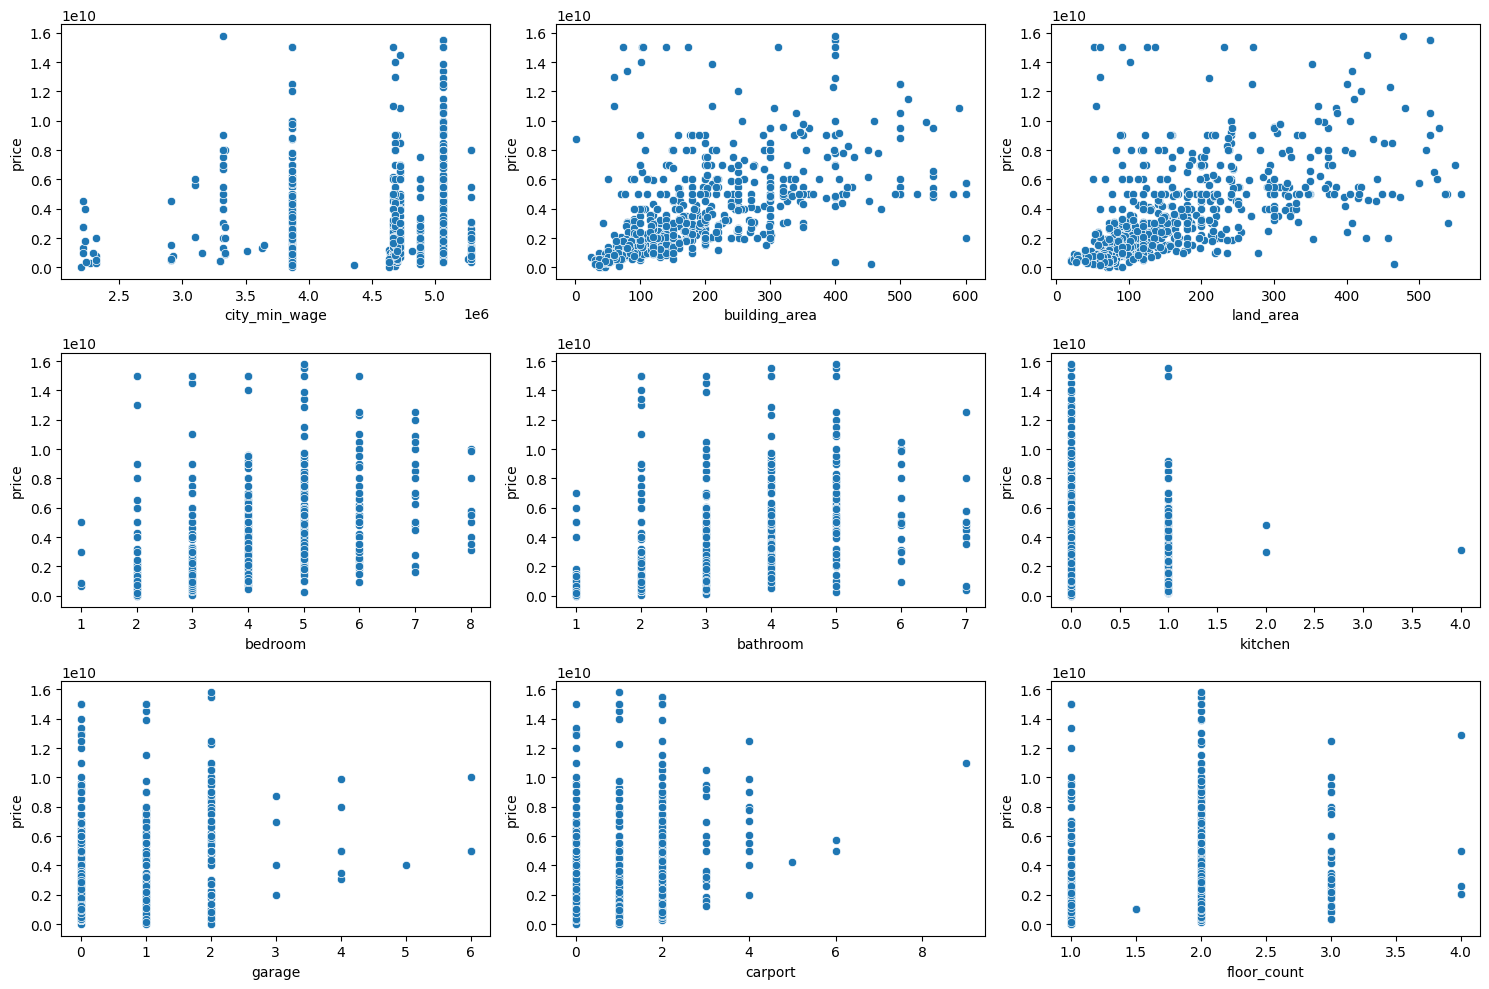

In [ ]:
cols_num = num_x.columns.to_list()

fig = plt.figure(facecolor='w', figsize=(15, 10))

for i, col in list(enumerate(cols_num)):
  ax = fig.add_subplot(3,3,i+1)
  sns.scatterplot(x=num_x[col], y=y['price'])
  fig.tight_layout()

plt.show()

In [29]:
x_select = num_x.join(ctg_x)

In [30]:
#Feature Selection dengan Regresi Lasso

lasso_selection = LassoCV()

lasso_selection.fit(x_select, y)

lasso_selected = [col for col, coef in zip(x_select.columns, lasso_selection.coef_) if coef != 0]
print('Fitur yang terpilih berdasakan Regresi Lasso', lasso_selected)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitur yang terpilih berdasakan Regresi Lasso ['city_min_wage', 'building_area']


Berdasarkan hasil dari regresi lasso, koefisien yang tidak nol atau berkontribusi pada y (harga rumah) adalah **city_min_wage** dan **building_area**.

In [31]:
#Feature Selection dengan Random Forest Regresor

rfe = RandomForestRegressor(random_state=42)

rfe.fit(x_select, y)

rfe_selected = [col for col, importance in zip(x_select.columns, rfe.feature_importances_) if importance > 0.05]
print('Fitur yang terpilih berdasakan Random Forest Regressor', rfe_selected)

<ipython-input-31-0b50007ab378>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfe.fit(x_select, y)


Fitur yang terpilih berdasakan Random Forest Regressor ['city_min_wage', 'building_area', 'land_area']


In [32]:
x = x_select[['city_min_wage', 'building_area', 'land_area']]

# Regression Fitting

,city_min_wage,land_area
1,5067381,452
2,4878612,375


In [64]:
#Split data dengan KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = LinearRegression(fit_intercept=False)

models = []
fold_var = []
mae  = []
mape = []
r2 = []

# Fitur Regresi Lasso
for i, (train_index, test_index) in enumerate(kf.split(x)):
  x_train, x_test, y_train, y_test = x[['city_min_wage','building_area']].iloc[train_index], x[['city_min_wage','building_area']].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  models.append(model)
  fold_var.append(f'{i}_2')
  mae.append(mean_absolute_error(y_test, y_pred))
  mape.append(mean_absolute_percentage_error(y_test, y_pred))
  r2.append(r2_score(y_test, y_pred))
  print(f'Fold {i} Var 2 Success')

# Fitur Regresi Lasso
for i, (train_index, test_index) in enumerate(kf.split(x)):
  x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  models.append(model)
  fold_var.append(f'{i}_3')
  mae.append(mean_absolute_error(y_test, y_pred))
  mape.append(mean_absolute_percentage_error(y_test, y_pred))
  r2.append(r2_score(y_test, y_pred))
  print(f'Fold {i} Var 3 Success')

models_score = pd.DataFrame({
    'model': models,
    'fold_var': fold_var,
    'mae' : mae,
    'mape': mape,
    'r2': r2
})

Fold 0 Var 2 Success
Fold 1 Var 2 Success
Fold 2 Var 2 Success
Fold 3 Var 2 Success
Fold 4 Var 2 Success
Fold 5 Var 2 Success
Fold 6 Var 2 Success
Fold 7 Var 2 Success
Fold 8 Var 2 Success
Fold 9 Var 2 Success
Fold 0 Var 3 Success
Fold 1 Var 3 Success
Fold 2 Var 3 Success
Fold 3 Var 3 Success
Fold 4 Var 3 Success
Fold 5 Var 3 Success
Fold 6 Var 3 Success
Fold 7 Var 3 Success
Fold 8 Var 3 Success
Fold 9 Var 3 Success


In [65]:
models_score

,model,fold_var,mae,mape,r2
0,LinearRegression(fit_intercept=False),0_2,1.283828e+09,1.616686,0.482762
1,LinearRegression(fit_intercept=False),1_2,1.772437e+09,1.509221,0.224113
2,LinearRegression(fit_intercept=False),2_2,1.413043e+09,0.714031,0.392110
3,LinearRegression(fit_intercept=False),3_2,1.478582e+09,0.757174,0.513695
4,LinearRegression(fit_intercept=False),4_2,1.942228e+09,1.143499,0.197598
5,LinearRegression(fit_intercept=False),5_2,1.743817e+09,0.796119,0.470637
6,LinearRegression(fit_intercept=False),6_2,1.653802e+09,0.874805,0.502747
7,LinearRegression(fit_intercept=False),7_2,1.990857e+09,3.499080,0.116844
8,LinearRegression(fit_intercept=False),8_2,1.633074e+09,1.182522,0.278037
9,LinearRegression(fit_intercept=False),9_2,1.905286e+09,0.827657,0.456106


In [76]:
best_model = models_score[models_score['r2'] == models_score['r2'].max()].model.item()

In [78]:
features = x.columns.to_list()

coef = pd.DataFrame(data=best_model.coef_, columns=features)
coef.applymap("{0:3,.2f}".format)

,city_min_wage,building_area,land_area
0,141.06,"7,992,342.55","8,764,550.41"


In [80]:
filename = 'regression_houseprice.sav'
pickle.dump(model, open(filename, 'wb'))

# Data Analysis

In [ ]:
df = df_clean
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               810 non-null    int64  
 1   city             810 non-null    object 
 2   city_min_wage    810 non-null    int64  
 3   building_area    810 non-null    int64  
 4   land_area        810 non-null    int64  
 5   bedroom          810 non-null    int64  
 6   bathroom         810 non-null    int64  
 7   kitchen          810 non-null    int64  
 8   dining_room      810 non-null    int64  
 9   living_room      810 non-null    int64  
 10  storeroom        810 non-null    int64  
 11  laundry          810 non-null    int64  
 12  garage           810 non-null    int64  
 13  carport          810 non-null    int64  
 14  floor_count      810 non-null    float64
 15  cctv             810 non-null    int64  
 16  ac               810 non-null    int64  
 17  legality        

Text(0.5, 0, 'Harga (dalam ratus miliar)')

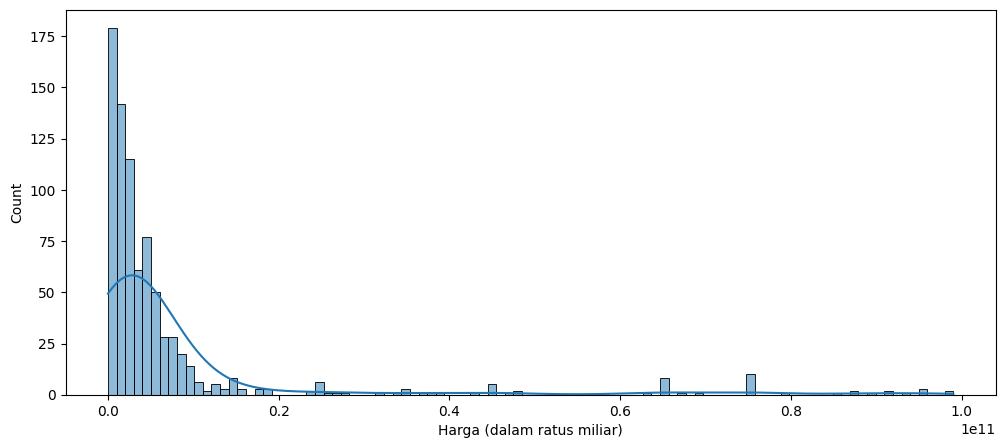

In [ ]:
fig = plt.figure(facecolor='w', figsize=(12, 5))
sns.histplot(x=df['price'], kde=True)
plt.xlabel('Harga (dalam ratus miliar)')

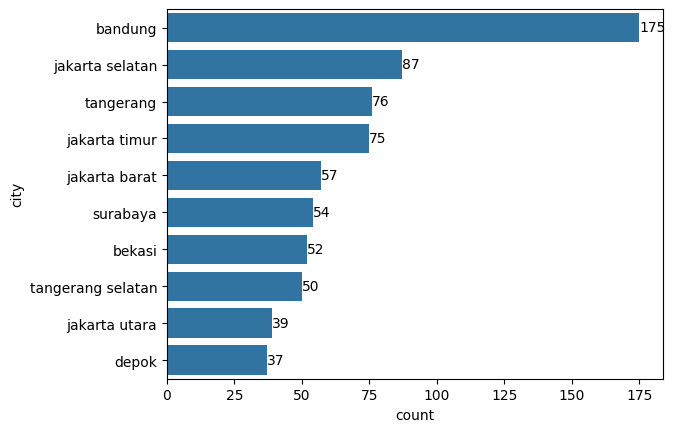

In [ ]:
city10 = df['city'].value_counts().head(10)
city10 = city10.reset_index()
city10 = city10.rename(columns={'index': 'city', 'city': 'count'})
ax = sns.barplot(data=city10, x='count', y='city', legend=False)
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

Text(0.5, 0, 'Harga (dalam puluh miliar)')

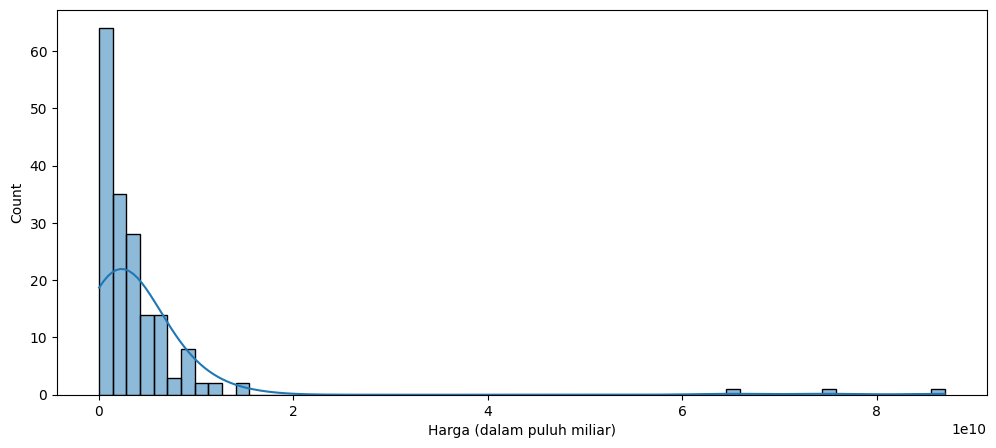

In [ ]:
df_bandung = df[df['city'] == 'bandung']

fig = plt.figure(facecolor='w', figsize=(12, 5))
sns.histplot(x=df_bandung['price'], kde=True)
plt.xlabel('Harga (dalam puluh miliar)')

<Axes: ylabel='Count'>

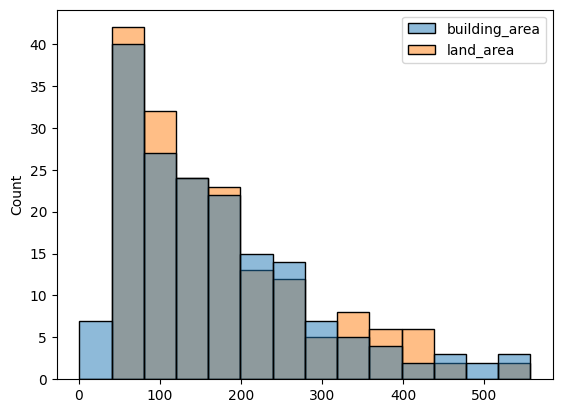

In [ ]:
sns.histplot(data=df_bandung[['building_area', 'land_area']])

UMR : 3868638.0 Cicilan : 11600541.0


Text(0, 0.5, 'Nominal (dalam puluh juta rupiah)')

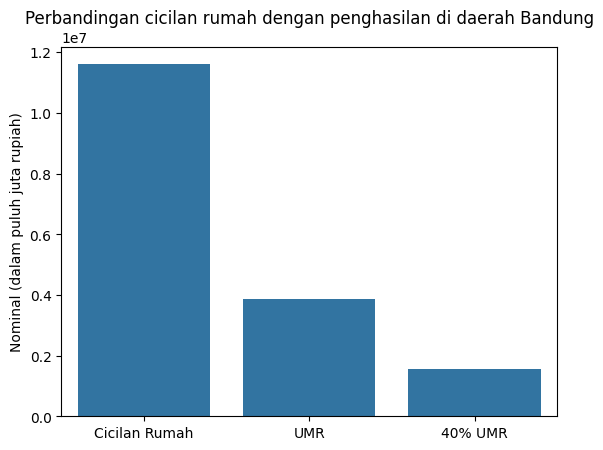

In [ ]:
umr_bandung = df_bandung['city_min_wage'].median()
med_installment = df_bandung['est_installment'].median()

print('UMR :', umr_bandung, 'Cicilan :', med_installment)

sns.barplot(x=['Cicilan Rumah', 'UMR', '40% UMR'], y=[med_installment, umr_bandung, umr_bandung*0.4])
plt.title('Perbandingan cicilan rumah dengan penghasilan di daerah Bandung')
plt.ylabel('Nominal (dalam puluh juta rupiah)')

UMR : 3129822 Cicilan : 12567253.0


Text(0, 0.5, 'Nominal (dalam puluh juta rupiah)')

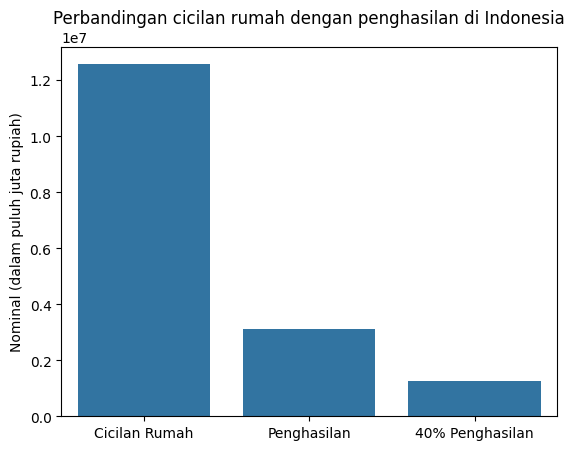

In [ ]:
umr_indo = 3129822
med_installment_indo = df['est_installment'].median()

print('UMR :', umr_indo, 'Cicilan :', med_installment_indo)

sns.barplot(x=['Cicilan Rumah', 'Penghasilan', '40% Penghasilan'], y=[med_installment_indo, umr_indo, umr_indo*0.4])
plt.title('Perbandingan cicilan rumah dengan penghasilan di Indonesia')
plt.ylabel('Nominal (dalam puluh juta rupiah)')

<Axes: xlabel='negotiable', ylabel='count'>

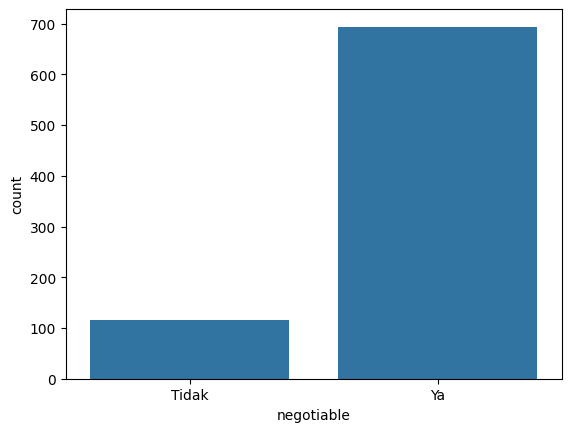

In [ ]:
df['negotiable'] = df['negotiable'].replace([0, 1], ['Tidak', 'Ya'])
sns.countplot(data=df, x='negotiable')

<Axes: >

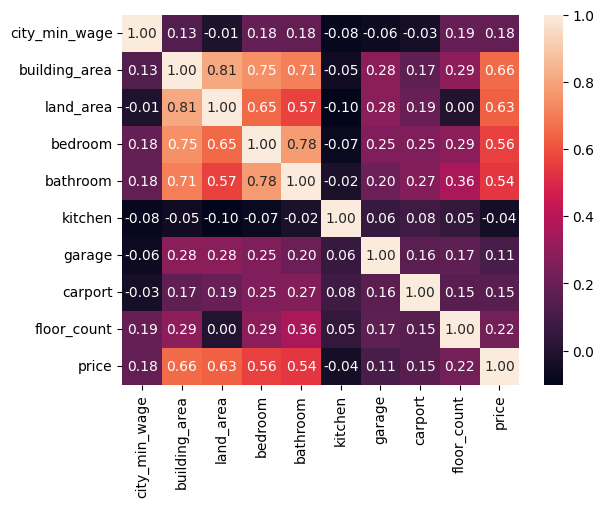

In [ ]:
num_feature = num_x.join(y)
spear_corr = num_feature.corr(method='spearman') #data tidak berdistribusi normal sehingga menggunakan korelasi Spearman
sns.heatmap(spear_corr, annot=True, fmt='.2f')

<Axes: >

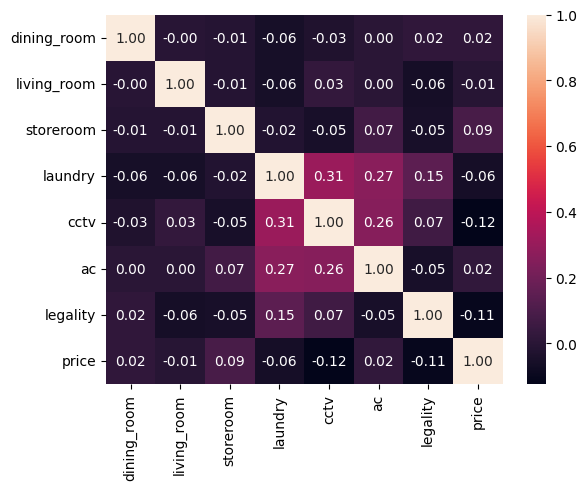

In [ ]:
ctg_feature = ctg_x.join(y)
kendall_corr = ctg_feature.corr(method='kendall') #data adalah kategorial, sehingga menggunakan korelasi Kendall Tau
sns.heatmap(kendall_corr, annot=True, fmt='.2f')